In [131]:
# given a json file / collection of sentences - run some basic analysis

import json
import os
import re
import time
import gzip
import itertools


import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


try:
    # python package (nlp) location - two levels up from this file
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    # add package to sys.path if it's not already there
    if src_path not in sys.path:
        sys.path.extend([src_path])
except NameError:
    print('issue with adding to path, probably due to __file__ not being defined')
    src_path = None


from nlp.utils import get_database, niave_long_to_short_name, get_knowledge_base_from_value_chain_data, get_most_confidence_bidirectional_pair
from nlp import get_configs_path, get_data_path


## Parameters
set parameter values for filtering - add more as needed

In [132]:
min_number_of_chars = 30

drop_bi_directional = True

## Load Data

In [133]:

# # ----
# # parameters
# # ----

# # if True will read articles from local json file: data/articles.json
# # - this can reduce burden on the remote database (network usage)
# read_local_articles = True

# # make number of sentences to combine
# max_num_sentences_to_combine = 5

# # ----
# # connect to database
# # ----

# # get credentials
# with open(get_configs_path("mongo.json"), "r+") as f:
#     mdb_cred = json.load(f)

# # get mongodb client - for connections
# client = get_database(username=mdb_cred["username"],
#                         password=mdb_cred["password"],
#                         clustername=mdb_cred["cluster_name"])

# # --
# # get knowledge base
# # --

# # ---
# # read in value chain data / knowledge base
# # ---

# vc = pd.DataFrame(list(client["knowledge_base"]["KB"].find(filter={})))

# # there are some missing comany names? exclude those
# vc = vc.loc[~pd.isnull(vc['Company Name'])]

# # the knowledge base
# kb = get_knowledge_base_from_value_chain_data(vc)

# # ---
# # read in article data - for reference
# # ---

# # read proof of concept data
# assert os.path.exists(get_data_path("articles.json")), \
#     f"{get_data_path('articles.json')} does not exist, get from the google drive and save locally"

# with open(get_data_path("articles.json"), "r") as f:
#     article_list = json.load(f)

# articles = {re.sub("\.json$", "", f["json_file"]): f
#             for f in article_list if "names_in_text" in f}


In [134]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 70)

In [135]:
#Read in VC File Locally Locally

assert os.path.exists(get_data_path("KB.csv")), \
    f"looks like: {get_data_path('KB.csv')}, pull from git to have it in the data folder"
vc = pd.read_csv(get_data_path("KB.csv"))

# there are some missing comany names? exclude those
vc = vc.loc[~pd.isnull(vc['Company Name'])]

# the knowledge base
kb = get_knowledge_base_from_value_chain_data(vc)


generating knowledge base 
taking most recent entries
'flipping' value chain: all Relationship = 'Customer' -> 'Supplier' 


In [136]:
#Load in Input file including with Weak Labels
assert os.path.exists(get_data_path("text_with_weak_labels.json")), \
    f"looks like: {get_data_path('text_with_weak_labels.json')}, copy from google drive data/text_with_weak_labels.json"

with open(get_data_path("text_with_weak_labels.json"), "r") as f:
    full_sents = json.load(f)

In [137]:
#Conver to DF and do simple processing

df = pd.DataFrame(full_sents)

# Create Label column for KB label
# NOTE: assume there are only two relation states
df['KB_label'] = [0 if i == "NA" else 1 for i in df['relation']]

In [138]:
# Removing instnaces with <=30 characters
print(f"dropping sentences below: {min_number_of_chars} characters")
print(f"entries prior to drop: {len(df)}")
df.drop(df[df['text'].apply(len)<=min_number_of_chars].index, inplace = True)
print(f"entries after: {len(df)}")

dropping sentences below: 30 characters
entries prior to drop: 146207
entries after: 146066


In [139]:

#For now replace () with [] -> This should not be necessary later
df.loc[:,"text_with_marker"] = [row[0].replace(row[1],'{'+row[1]+'}') for row in zip(df['text'],df['entity1'])]

df.loc[:,"text_with_marker"] = [row[0].replace(row[1],'['+row[1]+']') for row in zip(df['text_with_marker'],df['entity2'])]

# #Drop relation column
# df_data.drop('relation',axis=1,inplace=True)

## Removing bi-directional sentences

In [140]:
if drop_bi_directional:
    print("dropping bi-directional")
    # add a flag to sentences to determine if the pair is bi-directional
    bi_dir = pd.read_csv(get_data_path("bidirectional_supplier_relations.csv"))
    # determine which bi-directional
    bd = get_most_confidence_bidirectional_pair(bi_dir)
    # rename columns - to make merging with sentence data cleaner
    bd.rename(columns={"entity1": "entity1_full", "entity2": "entity2_full"}, inplace=True)

    # merge on the bi-directional most confidence value to sentences
    df = df.merge(bd[['entity1_full', 'entity2_full', "most_conf"]],
                  on=['entity1_full', 'entity2_full'],
                  how="left")
    # for those that are missing a most_conf value i.e. those that are not bi-directional
    # set their most_conf value to True
    df.loc[pd.isnull(df['most_conf']), "most_conf"] = True

    # select only those that are 'most confident'
    print(f"prior to dropping entries that have a less confident bi-directional "
          f"supplier relationship there were {len(df)}")
    df = df.loc[df['most_conf']]
    print(f"after there were: {len(df)}")

else:
    print("leaving bi-directional sentences")

dropping bi-directional
prior to dropping entries that have a less confident bi-directional supplier relationship there were 146066
after there were: 125281


## Num Sentences limited to 3

### Analysis

<AxesSubplot:>

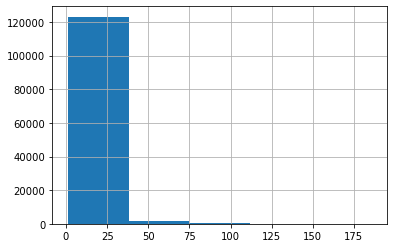

In [141]:
df['num_sentence'].hist(bins=5)

<AxesSubplot:>

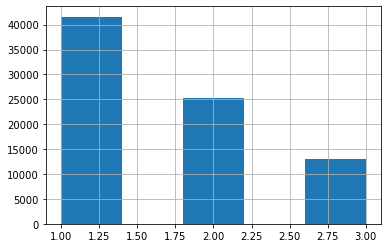

In [142]:
df.loc[df['num_sentence']<=3,'num_sentence'].hist(bins=5)

In [143]:
df.sort_values('num_sentence',ascending=False)[:20].loc[:,['entity1','entity2','text','num_sentence']]

,entity1,entity2,text,num_sentence
109086,Exxon Mobil,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,186
145886,Cadence,Exxon Mobil,Cadence Earnings Release 23-Apr-2018 AMC AMP.N Ameriprise Financia...,182
95190,Chevron,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,180
140130,Interpublic,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,179
105385,Exxon Mobil,Alphabet,Alphabet Earnings Release O 23-Apr-2018 AMC ZION.O Zions Bancorp Q...,178
136160,Halliburton,Phillips 66,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,176
145884,Cadence,Chevron,Cadence Earnings Release 23-Apr-2018 AMC AMP.N Ameriprise Financia...,176
141902,Interpublic,Cadence,Cadence Earnings Release 23-Apr-2018 AMC AMP.N Ameriprise Financia...,175
141871,Charter,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,173
114754,Chevron,Alphabet,Alphabet Earnings Release O 23-Apr-2018 AMC ZION.O Zions Bancorp Q...,172


### Removing the instances with >2 sentences

In [144]:
#Removing sentences with num_sentences>2, i.e. can only be 2 sentence long
df_short_dist = df.loc[df["num_sentence"]<3,:] 

print("{}% articles have max 1 sentence in between two entity mentions".format(np.round(df.loc[df["num_sentence"]<3,:].shape[0]/df.shape[0],2)*100))
print("{} out of {} sentences left".format(df.loc[df["num_sentence"]<3,:].shape[0],df.shape[0]))

df = df.loc[df["num_sentence"]<3,:] 

53.0% articles have max 1 sentence in between two entity mentions
66898 out of 125281 sentences left


## #Articles per pair

### Analysis

unique relations: ['Supplier' 'NA']
number of unique articles: 22294
count of 'relation'
           text
relation       
NA        27219
Supplier  39679
average extract sentences per article: 3.00


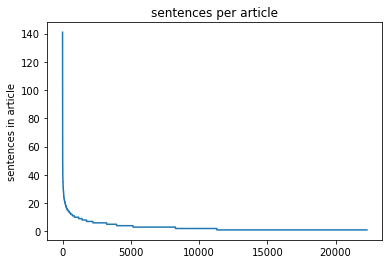

top articles:


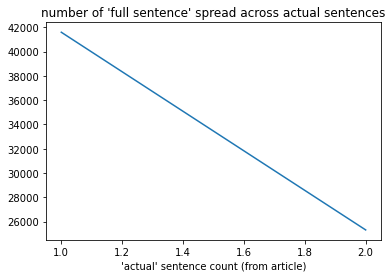

11.398534673709321

In [145]:
# ---
# get counts of occurrences / summary statistics
# ---

df.head()

print(f"unique relations: {df['relation'].unique()}")

print(f"number of unique articles: {len(df['article'].unique())}")

# ---
# count of relation
# ---
relation_count = pd.pivot_table(df,
                                index="relation",
                                values="text",
                                aggfunc="count")
print("count of 'relation'")
print(relation_count)

# ---
# sentences per articles
# ---

sent_per_art = pd.pivot_table(df, index='article', values="text", aggfunc='count')
sent_per_art = sent_per_art.reset_index()
sent_per_art.sort_values("text", ascending=False, inplace=True)

print(f"average extract sentences per article: {sent_per_art['text'].mean():.2f}")

plt.plot(sent_per_art['text'].values)
plt.title("sentences per article")
plt.ylabel("sentences in article")
plt.show()

# there is heavy skew
print("top articles:")
#print(sent_per_art.head(20))

sent_per_art.loc[sent_per_art['text'] < 10, 'text'].mean()

# ---
# sentence spread - entity pair can exist across multiple sentence - consider those
# ---

num_sent = pd.pivot_table(df,
                            index='num_sentence',
                            values="text",
                            aggfunc="count")

plt.plot(num_sent)
plt.title("number of 'full sentence' spread across actual sentences")
plt.xlabel("'actual' sentence count (from article)")
plt.show()

# ---
# sentences per pair
# ---

sentence_per_triple = pd.pivot_table(df,
                                        index=["entity1_full", "entity2_full", "relation"],
                                        values=["text"],
                                        aggfunc="count").reset_index()

sentence_per_triple['text'].mean()


In [146]:
#Looking at sentence per triple
sentence_per_triple['pair'] = sentence_per_triple['entity1_full'] + '-' + sentence_per_triple['entity2_full']
sentence_per_triple.sort_values('text',ascending=False)
label = np.ones(sentence_per_triple.shape[0]).astype(int)
label[sentence_per_triple['relation']=="NA"] = 0
sentence_per_triple.loc[:,'label'] = label


print("For Positive and Negative Examples")
print(sentence_per_triple.loc[:,['pair','text']].describe().round(0))
print("")


For Positive and Negative Examples
         text
count  5869.0
mean     11.0
std      61.0
min       1.0
25%       1.0
50%       2.0
75%       5.0
max    2092.0



In [147]:
print("For Positive")
print(sentence_per_triple.loc[sentence_per_triple['label']==1,['pair','text']].describe().round(0))
print('')

For Positive
         text
count  1469.0
mean     27.0
std      96.0
min       1.0
25%       2.0
50%       4.0
75%      15.0
max    2092.0



In [148]:
print("For Negative")
print(sentence_per_triple.loc[sentence_per_triple['label']==0,['pair','text']].describe().round(0))

For Negative
         text
count  4400.0
mean      6.0
std      42.0
min       1.0
25%       1.0
50%       1.0
75%       3.0
max    1841.0


In [149]:
sentence_per_triple

,entity1_full,entity2_full,relation,text,pair,label
0,A123 Systems Inc,Ford Motor Co,NA,1,A123 Systems Inc-Ford Motor Co,0
1,AAC Technologies Holdings Inc,LG Innotek Co Ltd,NA,3,AAC Technologies Holdings Inc-LG Innotek Co Ltd,0
2,AAC Technologies Holdings Inc,Panasonic Corp,NA,1,AAC Technologies Holdings Inc-Panasonic Corp,0
3,ANA Holdings Inc,Aeon Co Ltd,NA,1,ANA Holdings Inc-Aeon Co Ltd,0
4,ANA Holdings Inc,Airbus SE,Supplier,6,ANA Holdings Inc-Airbus SE,1
...,...,...,...,...,...,...
5864,Zoom Video Communications Inc,Verizon Communications Inc,NA,2,Zoom Video Communications Inc-Verizon Communications Inc,0
5865,Zynga Inc,Apple Inc,NA,2,Zynga Inc-Apple Inc,0
5866,Zynga Inc,Snap Inc,NA,2,Zynga Inc-Snap Inc,0
5867,eBay Inc,Microsoft Corp,Supplier,1,eBay Inc-Microsoft Corp,1


In [150]:
#See which pairs are with many examples 
sentence_per_triple.loc[sentence_per_triple['label']==0,['pair','text']].sort_values('text',ascending=False)[:30]

,pair,text
4320,Samsung Electronics Co Ltd-Apple Inc,1841
369,Amazon.com Inc-Apple Inc,1451
3238,Microsoft Corp-Amazon.com Inc,612
907,Bombardier Inc-Boeing Co,433
2553,Intel Corp-Apple Inc,431
854,Boeing Co-Airbus SE,378
456,Amazon.com Inc-Walmart Inc,365
3579,Netflix Inc-Apple Inc,316
5243,Toyota Motor Corp-Volkswagen AG,298
415,Amazon.com Inc-Microsoft Corp,273


In [151]:
#See impact on corpus
for i in [5,10,15,20,25,4000]:
    print("Negative: Cap: {}, examples left: ".format(i), sentence_per_triple.loc[sentence_per_triple['label'] ==0 ,"text"].clip(upper=i).sum())
    print("Positive: Cap: {}, examples left: ".format(i), sentence_per_triple.loc[sentence_per_triple['label'] ==1 ,"text"].clip(upper=i).sum())
    print("Total: Cap: {}, examples left: ".format(i), sentence_per_triple.loc[:,"text"].clip(upper=i).sum())
    print("")

Negative: Cap: 5, examples left:  9681
Positive: Cap: 5, examples left:  5027
Total: Cap: 5, examples left:  14708

Negative: Cap: 10, examples left:  12303
Positive: Cap: 10, examples left:  7840
Total: Cap: 10, examples left:  20143

Negative: Cap: 15, examples left:  13848
Positive: Cap: 15, examples left:  9903
Total: Cap: 15, examples left:  23751

Negative: Cap: 20, examples left:  14943
Positive: Cap: 20, examples left:  11592
Total: Cap: 20, examples left:  26535

Negative: Cap: 25, examples left:  15786
Positive: Cap: 25, examples left:  13021
Total: Cap: 25, examples left:  28807

Negative: Cap: 4000, examples left:  27219
Positive: Cap: 4000, examples left:  39679
Total: Cap: 4000, examples left:  66898



In [152]:
sentence_per_triple.sort_values('text',ascending=False)[:100]

,entity1_full,entity2_full,relation,text,pair,label
2073,General Motors Co,Ford Motor Co,Supplier,2092,General Motors Co-Ford Motor Co,1
4320,Samsung Electronics Co Ltd,Apple Inc,NA,1841,Samsung Electronics Co Ltd-Apple Inc,0
369,Amazon.com Inc,Apple Inc,NA,1451,Amazon.com Inc-Apple Inc,0
602,Apple Inc,Microsoft Corp,Supplier,1354,Apple Inc-Microsoft Corp,1
549,Apple Inc,Alphabet Inc,Supplier,844,Apple Inc-Alphabet Inc,1
...,...,...,...,...,...,...
639,Apple Inc,Taiwan Semiconductor Manufacturing Co Ltd,Supplier,125,Apple Inc-Taiwan Semiconductor Manufacturing Co Ltd,1
5281,Uber Technologies Inc,Alphabet Inc,NA,122,Uber Technologies Inc-Alphabet Inc,0
594,Apple Inc,LG Display Co Ltd,Supplier,122,Apple Inc-LG Display Co Ltd,1
520,American Airlines Group Inc,United Airlines Holdings Inc,Supplier,122,American Airlines Group Inc-United Airlines Holdings Inc,1


In [153]:
sent_per_art[:50]

,article,text
15449,9dab9253e2cea5262f91e2917579b4551f225ef9c92908a2cf76655d0b454578,141
7766,46bc17c301f9881f15bdafd19184ba5545895b162bd4f46c296f567a609e9d54,103
13015,805f831505530537d858a8335cfa498dec686a80cbfed406059369a90e3f2bff,94
4831,2a5bca0630b5e105d5d15e1d6bb8deaf2e43ea1acc1b7f09c0d0cf7043a5e7a5,59
819,06960d7b41a670cb50a1f8e7107e514dd5c82c63c849957ad6ce87ec7d036e02,58
5063,2c8e46fcd5978965ff63f18583b8f703db7a9d2e29f5d9f1aa44a07e00e9956a,58
4622,28a091a6457f753f8a319fb72b6fbe4830db4bf39cb30e99811c5c660f5440ab,56
16325,a8ee5360ffb75abf7b5016fe21bc53eb2ad872d6f9ed8ba92556e8bec5f7ee5a,55
1412,0bd3c52d7efada74fa318750007e052c0bcd5fe6221191daf3717fbc897ab623,54
6605,3b5173f9ba5a45605fb41d170231824f40e3b903f805dcee07b747455491b418,53


### Sampling articles such that each pair has a maximum of 20 articles

In [154]:
#Add a pair column to loop through
df.loc[:,'pair'] = df['entity1_full']+'|'+ df['entity2_full']

df_pivot = pd.pivot_table(df,
                                        index=["pair", "relation"],
                                        values=["text"],
                                        aggfunc="count").reset_index()



In [155]:
#Sampling Randomly
cutoff = 20
df_list = []
random_state = 13 

for pair in df_pivot['pair'].values:
    n = np.clip(df_pivot.loc[df_pivot['pair']==pair,'text'],0,cutoff).values[0]
    df_list.append(df.loc[df['pair'] == pair,:].sample(n,random_state=random_state,replace=False))

df = pd.concat(df_list,axis=0)
df.reset_index(drop=True,inplace=True)    

array([[<AxesSubplot:title={'center':'text'}>]], dtype=object)

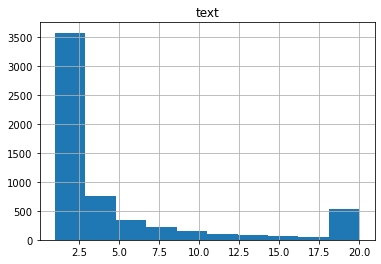

In [156]:
#Check the results
df_pivot_test = pd.pivot_table(df,
                                        index=["pair", "relation"],
                                        values=["text"],
                                        aggfunc="count").reset_index()

df_pivot_test.sort_values('text',ascending=False).hist()

## Splitting the Data into Train/Dev/Test

### Split functions (From Joe's Notebook with small amendment)

In [157]:
def stanford_split(kb, corpus, split_ratios = [0.6, 0.2, 0.2], random_seed = 0, verbose = True):
    np.random.seed(random_seed)

    assert sum(split_ratios) == 1, 'Split Ratios do not add up to 1'

    # Randomly split the subjects in the KB between train/dev/test splits 
    # TODO: Random number generation split does not create exact splits - make this exact with length split instead (but works for now)
    def subject_split(kb, split_ratios):
        subjects = pd.DataFrame(kb.subject.unique()).rename(columns = {0: 'subject'})
        subjects['split'] = [np.random.choice(3, p =  split_ratios) for _ in range(len(subjects))] 
        return subjects

    if verbose: pass

    # Merge split numbers for subjects (E1) back onto kb df
    kb_with_splits = kb.merge(subject_split(kb, split_ratios), how = 'left', on = 'subject')

    split_dict = {sbj: split for sbj, split in zip(kb_with_splits.subject, kb_with_splits.split)}

    corpus_with_splits = corpus.copy()

    # Use stanford Rule:
    # If E1 in corpus in a KB split -> place sentence to that split.
    # Else if E2 in corpus in a KB split -> place sentance to that split.
    # If neither of above, assign sentence to random split.
    splits = []
    count_not_matched = 0
    for E1, E2 in zip(corpus_with_splits.entity1_full, corpus_with_splits.entity2_full): 
        if E1 in split_dict.keys():
            splits.append(split_dict[E1])
        elif E2 in split_dict.keys():
            splits.append(split_dict[E2])
        else:
            splits.append(np.random.choice(3, p = split_ratios))
            if verbose: print('{}, {} not in KB split' .format(E1, E2))
            count_not_matched += 1
    print('Total of {} entries in corpus not matched to KB. \n' .format(count_not_matched))
    corpus_with_splits['split'] = splits

    # if verbose:
    print('KB split ratios: \n {} \n' .format(kb_with_splits.split.value_counts(normalize = True)))
    print('Corpus split ratios: \n {} \n' .format(corpus_with_splits.split.value_counts(normalize = True)))

    return kb_with_splits, corpus_with_splits


In [158]:
def corpus_density_based_split(corpus, kb, split_ratios = np.array([0.6,0.2,0.2]), labelcol = 'label', random_seed = 0, verbose = True):
    np.random.seed(random_seed)
    corp = corpus.copy()
    _kb = kb.copy()

    # Create an alphabetically sorted (E1, E2) tuple column of the two entities mentioned in each row
    corp['relation_tuple'] = [tuple(sorted([E1, E2])) for E1, E2 in zip(corp.entity1_full, corp.entity2_full)]       
    
    # Create a df which contains the number of entries per unique E1,E2 pair in corpus and sort in descending order
    corpus_counts = corp.groupby(['relation_tuple']).agg('size').reset_index().sort_values(by = 0, ascending=False).rename(columns = {0: 'sentence_counts'})

    _counts_per_split = corpus_counts.sentence_counts.sum() * split_ratios
    _counts_cumsum = _counts_per_split.cumsum()
    print('Aim to have approx {} entries per train/dev/test split, respectively.\n' .format(_counts_per_split))

    # Shuffle this to get rid of numerical order 
    shuffled_corpus_counts = corpus_counts.sample(frac=1, random_state = 42) # Perhaps we can also find deterministic "shuffle"

    # Now add column which gives cumulative counts of sentences down Pairs
    shuffled_corpus_counts['sentence_cumsum'] = np.cumsum(shuffled_corpus_counts.sentence_counts)

    def assign_splits(corpus_counts, counts_cumsum):
        splits = []
        for scs in corpus_counts.sentence_cumsum:
            if scs <= counts_cumsum[0]: splits.append(0)
            elif scs > counts_cumsum[0] and scs <= counts_cumsum[1]: splits.append(1)
            else: splits.append(2)
        return splits

    shuffled_corpus_counts['split'] = assign_splits(shuffled_corpus_counts, _counts_cumsum)

    corp = corp.merge(shuffled_corpus_counts, how = 'left', on = 'relation_tuple')

    # Now merge corpus-based created splits onto KB 
    # MANY KB ENTRIES WILL NOT HAVE MATCHES 
    _kb['relation_tuple'] = [tuple(sorted([E1, E2])) for E1, E2 in zip(_kb.subject.astype(str), _kb.object.astype(str))]

    _kb = _kb.merge(corp[['relation_tuple', 'split']], how = 'left', on = 'relation_tuple')

    if verbose:
        corp_vals = corp.split.value_counts(normalize = False)
        corp_ratios = round(corp.split.value_counts(normalize = True),3)
        corp_balance = round(corp.groupby('split').agg('mean')[labelcol],2)

        kb_vals = _kb.fillna(99).split.value_counts(normalize = False)
        kb_ratios = round(_kb.fillna(99).split.value_counts(normalize = True),3)

        print('Corpus split:')
        print('Train: {} ({}%) \nDev: {} ({}%)\nTest: {} ({}%) \n' .format(corp_vals[0], corp_ratios[0]*100, corp_vals[1], corp_ratios[1]*100, corp_vals[2], corp_ratios[2]*100))

        print('Class Balance (positive class):')
        print('Train: {}%\nDev: {}%\nTest: {}% \n' .format(corp_balance[0]*100, corp_balance[1]*100, corp_balance[2]*100) )

        print('KB split:')
        print('Train: {} ({}%)\nDev: {} ({}%)\nTest: {} ({}%)' .format(kb_vals[0], kb_ratios[0]*100, kb_vals[1], kb_ratios[1]*100, kb_vals[2], kb_ratios[2]*100))
        print('Total of {} (E1,E2) ordered pairs in KB not assigned. \n' .format(kb_vals[99]))
    
    return corp, _kb

### Results from each Split Function

In [159]:
#Add column names as required by the functions
kb.columns = ['subject', 'object','relation','Last Update Date', "Confidence Score (%)"]

In [160]:
#Stanford split
_, df_split_stanford = stanford_split(kb, df)
#Corpus SPlit
df_split_dense, _ = corpus_density_based_split(df, kb, split_ratios = np.array([0.6,0.2,0.2]), labelcol= "KB_label", verbose = True)


Finisar Corp, Inphi Corp not in KB split
Foster Electric Co Ltd, Sumida Corp not in KB split
Hirose Electric Co Ltd, Foster Electric Co Ltd not in KB split
LG Innotek Co Ltd, Nexen Tire Corp not in KB split
Martinrea International Inc, Linamar Corp not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Pivotal Software Inc, Carbon Black Inc not in KB split
Samsung C&T Corp, Samsung Group not in KB split
Shenzhen Sunway Communication Co Ltd, Suzhou Anjie Technology Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co

In [161]:
df_split_stanford.loc[i,'entity2']

'Acer'

<AxesSubplot:>

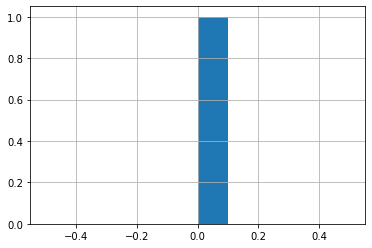

In [162]:
#Look at how a given entity2 is distribution
i = 0
#df_split_stanford.loc[df_split_stanford['entity2']==df_split_stanford.loc[i,'entity2'],'split'].hist()
df_split_stanford.loc[df_split_stanford['entity1']==df_split_stanford.loc[i,'entity1'],'split'].hist()

In [163]:
df_split_dense.loc[i,'entity2']

'Ford'

<AxesSubplot:>

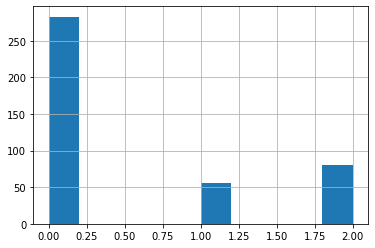

In [164]:
#Look at how a given entity2 is distribution
i = 0
df_split_dense.loc[df_split_dense['entity2']==df_split_dense.loc[i,'entity2'],'split'].hist()

In [165]:
def pd_entropy(labels):
  vc = pd.Series(labels).value_counts(normalize=True, sort=False)
  return np.sum(-(vc * np.log(vc)))

def corpus_entropy(df_split,entity='entity1'):
  return pd.DataFrame([pd_entropy(df_split.loc[df_split[entity]==i,'split']) for i in df_split[entity].unique()],index=df_split[entity].unique(),columns=["entropy_" +entity])


In [166]:
entropy_stanford_entity1 = corpus_entropy(df_split_stanford,entity='entity1').describe()
entropy_stanford_entity2 = corpus_entropy(df_split_stanford,entity='entity2').describe()
entropy_stanford_pair = corpus_entropy(df_split_stanford,entity='pair').describe()
entropy_stanford = pd.concat([entropy_stanford_entity1,entropy_stanford_entity2,entropy_stanford_pair],axis=1)
print("Stanford Split:")
entropy_stanford.round(2)

Stanford Split:


,entropy_entity1,entropy_entity2,entropy_pair
count,585.00,620.00,5869.00
mean,0.04,0.41,0.00
std,0.16,0.38,0.02
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.45,0.00
75%,0.00,0.69,0.00
max,1.10,1.10,1.04


In [167]:
entropy_dense_entity1 = corpus_entropy(df_split_dense,entity='entity1').describe()
entropy_dense_entity2 = corpus_entropy(df_split_dense,entity='entity2').describe()
entropy_dense_pair = corpus_entropy(df_split_dense,entity='pair').describe()
entropy_dense = pd.concat([entropy_dense_entity1,entropy_dense_entity2,entropy_dense_pair],axis=1)
print("Dense Split:")
entropy_dense.round(2)

Dense Split:


,entropy_entity1,entropy_entity2,entropy_pair
count,585.00,620.00,5869.0
mean,0.50,0.47,0.0
std,0.40,0.39,0.0
min,0.00,0.00,0.0
25%,0.00,0.00,0.0
50%,0.64,0.56,0.0
75%,0.85,0.80,0.0
max,1.10,1.10,0.0


In [168]:
#Split the dataframe into train/dev/test
_, df = stanford_split(kb, df)

Finisar Corp, Inphi Corp not in KB split
Foster Electric Co Ltd, Sumida Corp not in KB split
Hirose Electric Co Ltd, Foster Electric Co Ltd not in KB split
LG Innotek Co Ltd, Nexen Tire Corp not in KB split
Martinrea International Inc, Linamar Corp not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Pivotal Software Inc, Carbon Black Inc not in KB split
Samsung C&T Corp, Samsung Group not in KB split
Shenzhen Sunway Communication Co Ltd, Suzhou Anjie Technology Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co

# Store file sentences for later use

In [169]:
#Full Data 
df.to_csv(get_data_path() + "/df_full.tsv",sep='\t')
# #Splits under Stanford Split
# df_split_stanford.loc[df_split_stanford['split']==0,:].to_csv(get_data_path() + "/df_train_stanford.tsv",sep='\t')
# df_split_stanford.loc[df_split_stanford['split']==1,:].to_csv(get_data_path() + "/df_val_stanford.tsv",sep='\t')
# df_split_stanford.loc[df_split_stanford['split']==2,:].to_csv(get_data_path() + "/df_test_stanford.tsv",sep='\t')
# #Splits under Dense Split
# df_split_dense.loc[df_split_dense['split']==0,:].to_csv(get_data_path() + "/df_train_dense.tsv",sep='\t')
# df_split_dense.loc[df_split_dense['split']==1,:].to_csv(get_data_path() + "/df_val_dense.tsv",sep='\t')
# df_split_dense.loc[df_split_dense['split']==2,:].to_csv(get_data_path() + "/df_test_dense.tsv",sep='\t')
#Store KB File
kb.to_csv(get_data_path() + "/kb_supplier_rel_only.tsv",sep='\t')